# Shared Interest XAITK Integration Example <a name="XAITK-Saliency-Shared-Interest"></a>
This example notebook makes use of the base [shared-interest](https://github.com/mitvis/shared-interest/blob/main/shared_interest/examples/shared_interest_example.ipynb) example and explores integrating ``xaitk-saliency``, followed by computing the shared interest scores on the generated saliency maps.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/xaitk-jatic/blob/main/docs/examples/shared_interest/xaitk-shared_interest.ipynb)

## Environment Setup <a name="environment-setup"></a>

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/xaitk-jatic/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

**This notebook won't behave as expected in Colab because Colab doesn't have access to the external data files required.** This notebook requires the data in docs/examples/shared_interest/data/input/{annotations,images} which can be uploaded with the folder icon in the left menu.

In [1]:
import sys  # noqa:F401

!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q torch
!{sys.executable} -m pip install -q torchvision
!{sys.executable} -m pip install -q tqdm
!{sys.executable} -m pip install -q matplotlib

## Install the Shared-Interest library <a name="Install-Shared-Interest"></a>

Installation of the Shared Interest library is done from a modified forked repository [here](https://github.com/barry-ravichandran/shared-interest/tree/dev/datasets-import). This repository contains modifications that overcomes the ``shared-interest`` import errors that were encountered in the CI pipeline environment. 

In [2]:
!{sys.executable} -m pip install -q "git+https://github.com/barry-ravichandran/shared-interest.git@dev/datasets-import#egg=shared_interest"

## Load Model and Setup Transforms <a name="Model-Transforms-Shared-Interest"></a>

For this example, we make use of the torch `ResNet-50` pretrained model. Following this, we setup the augmentations/transforms for the input dataset.

In [3]:
from typing import Any, Optional

import PIL.Image
import torch  # type: ignore
import torchvision.models as models  # type: ignore
import torchvision.transforms as transforms  # type: ignore
from typing_extensions import override

CUDA_AVAILABLE = torch.cuda.is_available()
model = models.resnet50(pretrained=True)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

model_input_size = (256, 256)
model_mean = [0.485, 0.456, 0.406]

model_loader = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(model_input_size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=model_mean, std=[0.229, 0.224, 0.225]),
    ],
)

img_loader = transforms.Compose(
    [
        transforms.Resize(model_input_size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=model_mean, std=[0.229, 0.224, 0.225]),
    ],
)

ground_truth_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(model_input_size, PIL.Image.NEAREST),  # type: ignore
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ],
)

reverse_image_transform = transforms.Compose(
    [
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ],
)

/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Configure ImageNet Dataloader <a name="ImageNet-DataLoader-Shared-Interest"></a>

The cell below sets up the torch DataLoader object for the ImageNet dataset.

In [4]:
import os

import torch.utils.data  # type: ignore
from shared_interest.datasets.imagenet import ImageNet  # type: ignore

imagenet_dir = "./data/input"
image_dir = os.path.join(imagenet_dir, "images")
annotation_dir = os.path.join(imagenet_dir, "annotations")
dataset = ImageNet(image_dir, annotation_dir, img_loader, ground_truth_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=40, pin_memory=True)

/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Configure Class labels for ImageNet <a name="Class-Labels-Shared-Interest"></a>

We setup the ImageNet class list on the fly by downloading from the link below and setting up the class labels and it's corresponding indices. 
Note: This list can be constrained to a subset of ImageNet classes based on a user's input of a `custom_categories_list`. 

In [5]:
import requests


def get_sal_labels(
    classes_file: str,
    custom_categories_list: Optional[list[str]] = None,
) -> tuple[list[str], list[int]]:
    """
    Retrieve saliency class labels and their corresponding indices.

    If the `classes_file` does not exist, it is downloaded from a predefined URL.
    Optionally, a custom list of categories can be provided to override the default categories.

    Args:
        classes_file (str): Path to the file containing the list of class labels.
        custom_categories_list (Optional[List[str]]): A custom list of category labels.
            If provided, this list will be used instead of the categories in the file.

    Returns:
        Tuple[List[str], List[int]]:
            - `sal_class_labels` (List[str]): A list of saliency class labels.
            - `sal_class_idxs` (List[int]): A list of indices of the saliency class labels in the file's category list.

    Raises:
        ValueError: If the URL scheme for downloading the file is not "https://".
        requests.exceptions.RequestException: If there is an issue with the file download.

    Notes:
        - The function assumes that the file at `classes_file` contains one category per line.
        - If `custom_categories_list` is provided, it should match some or all of the categories in the file.

    Example:
        >>> classes_file = "imagenet_classes.txt"
        >>> custom_list = ["cat", "dog", "car"]
        >>> labels, indices = get_sal_labels(classes_file, custom_list)
        >>> print(labels)  # ["cat", "dog", "car"]
        >>> print(indices)  # [281, 207, 468]  (Example indices)
    """
    if not os.path.isfile(classes_file):
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

        # Validate the URL scheme
        if url.startswith("https://"):
            response = requests.get(url, stream=True, timeout=1000)
            response.raise_for_status()  # Ensure the request was successful
            with open(classes_file, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        else:
            raise ValueError("Invalid URL scheme. Only 'https://' is allowed.")

    with open(classes_file) as f:
        categories = [s.strip() for s in f]

    sal_class_labels = custom_categories_list if custom_categories_list is not None else categories

    sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]

    return sal_class_labels, sal_class_idxs


data_path = "./data"
if not os.path.exists(data_path):
    os.makedirs(data_path)

classes_file = os.path.join(data_path, "imagenet_classes.txt")
sal_class_labels, sal_class_idxs = get_sal_labels(classes_file)

## SMQTK Classifier Wrapper <a name="SMQTK-Classifier-Shared-Interest"></a>

The `ClassifyImage` wrapper takes in `numpy.ndarray` images as an input and for every single image returns an output of classwise confidence scores. This output format is required to comply with our `xaitk-saliency` algorithm implementation.

In [6]:
from collections.abc import Iterable, Iterator, Sequence

import numpy as np
import torch.nn.functional  # type: ignore
from smqtk_classifier.interfaces.classify_image import ClassifyImage


class TorchResnet(ClassifyImage):
    """
    A wrapper for a Torch ResNet model to classify images using the SMQTK `ClassifyImage` interface.

    This class provides an adapter for PyTorch-based ResNet models to integrate with SMQTK pipelines,
    enabling image classification with predicted class probabilities.

    Attributes:
        sal_class_labels (Sequence[str]): List of human-readable class labels.
        sal_class_idxs (Sequence[int]): List of class indices corresponding to `sal_class_labels`.
        model (torch.nn.Module): The ResNet model for feature extraction.
        model_loader (Callable): A callable to preprocess input images for the model.
        CUDA_AVAILABLE (bool): Indicates whether CUDA is available for computation.
    """

    @override
    def get_labels(self) -> Sequence[str]:
        return sal_class_labels

    @torch.no_grad()
    @override
    def classify_images(self, img_iter: Iterable[np.ndarray]) -> Iterator[dict[str, float]]:
        for img in img_iter:
            image_tensor = model_loader(img).unsqueeze(0)  # type: ignore
            if CUDA_AVAILABLE:
                image_tensor = image_tensor.cuda()

            feature_vec = model(image_tensor)

            class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()

            yield dict(zip(sal_class_labels, class_conf[sal_class_idxs]))

    @override
    def get_config(self) -> dict[str, Any]:
        return {}


blackbox_classifier, blackbox_fill = TorchResnet(), np.uint8(np.asarray(model_mean) * 255).tolist()

## Initialize Saliency Algorithm <a name="Saliency-Algorithm-Shared-Interest"></a>

We create an instance of `RISEStack`, an implementation of the `GenerateImageClassifierBlackboxSaliency` interface, to carry out our image perturbation and heatmap generation.

In [7]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.rise import RISEStack

sal_generator = RISEStack(n=200, s=8, p1=0.5, seed=1, threads=4, debiased=True)
sal_generator.fill = blackbox_fill

## Modified `run` function that swaps in the `xaitk-saliency` algorithm <a name="Swap-Saliency-Shared-Interest"></a>

The `run` function below is a modified version from the original shared-interest example [notebook](https://github.com/mitvis/shared-interest/blob/main/shared_interest/examples/shared_interest_example.ipynb) where the `Vanilla Gradients` saliency algorithm is swapped with an implementation of the `RISE` algorithm from `xaitk-saliency`.

In [8]:
import torch.nn.functional  # type: ignore
from shared_interest.shared_interest import shared_interest  # type: ignore
from shared_interest.util import binarize_std  # type: ignore
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from tqdm import tqdm


def run(  # noqa:C901
    model: torch.nn.Module,
    dataloader: DataLoader,
    saliency_method: RISEStack,
    stop_after: Optional[int] = None,
) -> tuple[np.ndarray, np.ndarray, dict[str, np.ndarray], np.ndarray]:
    """
    Run model inference and saliency computation on a dataset.

    This function performs inference using the given model on the provided dataloader, computes accuracy,
    generates saliency maps using the specified saliency method, and calculates Shared Interest scores
    for the dataset.

    Args:
        model (torch.nn.Module): The model used for inference.
        dataloader (DataLoader): The dataloader providing batches of images, ground truths, and labels.
        saliency_method (Callable[[np.ndarray, Callable], np.ndarray]): A method to generate saliency maps,
            taking an image and a blackbox classifier as input.
        stop_after (Optional[int], optional): The maximum number of batches to process. If None, processes
            all batches. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray, Dict[str, np.ndarray], np.ndarray]:
            - `total_saliency` (np.ndarray): All computed saliency maps.
            - `total_saliency_masks` (np.ndarray): Binarized saliency maps.
            - `total_shared_interest_scores` (Dict[str, np.ndarray]): Shared Interest scores for all batches.
            - `total_predictions` (np.ndarray): Predicted labels for all inputs.

    Notes:
        - The function supports early stopping using the `stop_after` parameter.
        - Uses GPU if available; falls back to CPU otherwise.
    """
    device = "cpu"
    if CUDA_AVAILABLE:
        device = "cuda"

    accuracy = 0
    total_shared_interest_scores = {
        "iou_coverage": np.array([]),
        "ground_truth_coverage": np.array([]),
        "saliency_coverage": np.array([]),
    }

    total_predictions = np.array([])
    total_saliency_masks = np.array([[[]]])
    total_saliency = np.array([[[]]])

    for i, (images, ground_truth, labels) in enumerate(tqdm(dataloader)):
        sal_maps = np.empty((0, 224, 224))

        with torch.no_grad():
            ground_truth = ground_truth.numpy()
            labels = labels.numpy()
            images = images.to(device)

            # Compute model predictions
            output = model(images)

            preds = torch.argmax(output, dim=1).detach().cpu().numpy()
            total_predictions = np.concatenate((total_predictions, preds))

            # Update metrics
            accuracy += accuracy_score(labels, preds)

        # Compute saliency
        im_numpy = images.cpu().numpy().astype("uint8")

        for c, img in enumerate(im_numpy):
            img = img.transpose((1, 2, 0))
            sal_map = saliency_method(img, blackbox_classifier)
            sal_map = sal_map[preds[c], :, :]
            sal_map = np.clip(sal_map, 0, 1)
            sal_map = np.expand_dims(sal_map, axis=0)
            sal_maps = np.vstack((sal_maps, sal_map))

        saliency = sal_maps
        saliency_masks = binarize_std(saliency)

        if i == 0:
            total_saliency_masks = saliency_masks
            total_saliency = saliency
        else:
            total_saliency_masks = np.concatenate((total_saliency_masks, saliency_masks))
            total_saliency = np.concatenate((total_saliency, saliency))

        # Compute Shared Interest scores
        for score in total_shared_interest_scores:
            shared_interest_scores = shared_interest(ground_truth, saliency_masks, score=score)
            total_shared_interest_scores[score] = np.concatenate(
                (total_shared_interest_scores[score], shared_interest_scores),
            )

        # Stop early for this example notebook
        if stop_after and i == stop_after:
            break
    accuracy /= i + 1  # type: ignore
    print(f"Accuracy: {accuracy}")
    return total_saliency, total_saliency_masks, total_shared_interest_scores, total_predictions


saliency, saliency_masks, shared_interest_scores, predictions = run(model, dataloader, sal_generator, stop_after=0)

  0%|          | 0/1 [00:00<?, ?it/s]/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1/1 [01:04<00:00, 64.55s/it]

Accuracy: 1.0


## Saliency Visualization with Shared Interest Scores <a name="Saliency-Scores-Shared-Interest"></a>

The section below visualizes the saliency map results for the image classification model and reports the following three Shared Interest scores on a specified set of queried sample images:
- ``IoU Coverage (IC)`` - The number of features in both the ground truth and saliency sets divided by the number of features in at least one of the ground truth and saliency sets.
- ``Ground Truth Coverage (GTC)`` - The proportion of the ground truth feature set that is also part of the saliency feature set.
- ``Saliency Coverage (SC)`` - The proportion of the saliency feature set that is also part of the ground truth feature set.

In [9]:
import matplotlib.pyplot as plt  # type: ignore
from matplotlib.axes import Axes
from matplotlib.figure import FigureBase


def ax_off(ax: Axes) -> None:
    """
    Disable all ticks and tick labels on the given matplotlib Axes.

    Args:
        ax (plt.Axes): The matplotlib Axes object to modify.

    Returns:
        None
    """
    ax.tick_params(
        which="both",
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )


def display_images(data_inds: list[int], dataset: ImageNet) -> FigureBase:
    """
    Display a set of images with their associated ground truth, saliency masks, and other visualizations.

    Args:
        data_inds (list[int]): Indices of the images in the dataset to be displayed.
        dataset (ImageNet): The dataset containing the images.

    Returns:
        matplotlib.figure.Figure: The matplotlib figure containing the visualizations.

    Visualizations:
        - Column 1: Original image with predicted and true labels.
        - Column 2: Image masked by the ground truth.
        - Column 3: Image with a binarized saliency overlay and performance metrics.
        - Column 4: Continuous saliency heatmap overlaid on the original image.
    """
    data = [dataset[i] for i in data_inds]
    n = len(data)
    fig, ax = plt.subplots(nrows=n, ncols=4, figsize=(10, 4 * n))
    np.vectorize(ax_off)(ax)

    for i, (image, ground_truth, label) in enumerate(data):
        data_ind = data_inds[i]
        ax[i][0].imshow(reverse_image_transform(image))
        ax[i][0].set_title(
            f"Image\nLabel: {sal_class_labels[int(label)]}\nPred: {sal_class_labels[int(predictions[data_ind])]}",
        )

        masked_image = image * ground_truth.unsqueeze(0)
        ax[i][1].imshow(reverse_image_transform(masked_image))
        ax[i][1].set_title("Ground Truth\n")

        saliency_image = np.array(reverse_image_transform(image)) * np.expand_dims(saliency_masks[data_ind], axis=2)
        ax[i][2].imshow(saliency_image)
        ax[i][2].set_title(
            "Binarized Saliency\nIoU: {}, SC: {},\nGTC: {}".format(
                shared_interest_scores["iou_coverage"][data_ind],
                shared_interest_scores["saliency_coverage"][data_ind],
                shared_interest_scores["ground_truth_coverage"][data_ind],
            ),
        )
        ax[i][3].imshow(image.numpy().transpose((1, 2, 0)), alpha=0.7)
        z = ax[i][3].imshow(saliency[data_ind], cmap="jet", alpha=0.3, vmin=0, vmax=1)
        ax[i][3].axis("off")
        ax[i][3].set_title("Continuous\nSaliency")
        fig.colorbar(z, ax=ax[i][3], shrink=0.5)

    return fig

### Saliency Map Generation for ImageNet Examples <a name="Default-Examples-Shared-Interest"></a>

The cell below contains the saliency map results for the ImageNet examples shown in the original shared-interest [notebook](https://github.com/mitvis/shared-interest/blob/main/shared_interest/examples/shared_interest_example.ipynb). We visualize both the `binarized` and the `continuous` saliency maps in the figures below. The `binarized` saliency map provides a spatial coverage of the image areas under focus. Whereas, the `continuous` saliency map provides a heatmap depicting the important feature regions in the image. (Note: The saliency values are clipped to display only the positive saliency regions).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


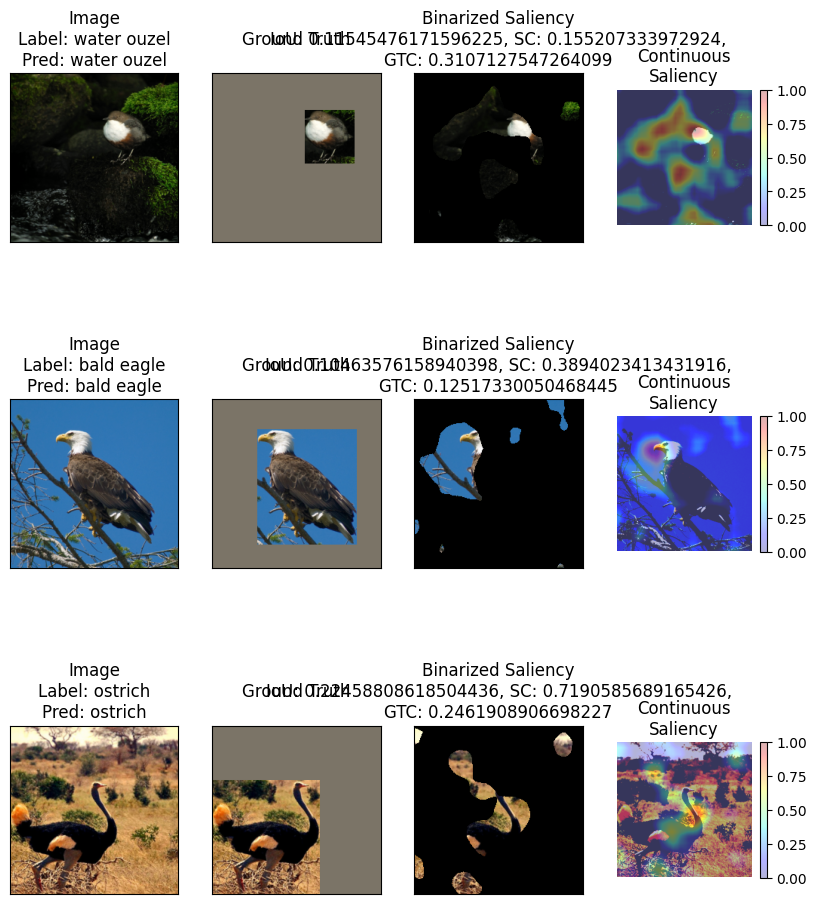

In [10]:
fig = display_images([1, 2, 0], dataset)

### Querying examples based on metric values <a name="Querying-Examples-Shared-Interest"></a>

In the cell below, we query specific examples based on a high SC score. We are primarily focusing on the following scenario for the example visualizations below:
- `Sufficient Subset` examples have a high SC and low GTC where a subset of the human-annotated features are important for the model and the model makes a correct prediction.

In addition to this, there are 7 more scenarios for which this can be extended to:
-  `Insufficient Subset` examples have a high SC and low GTC where a subset of the human-annotated features are important for the model but the model makes an incorrect prediction.
- `Human Aligned` examples have high IoU with correct model predictions.
- `Sufficient Context` examples have low IoU with correct model predictions.
- `Context Dependent` examples have high GTC and low SC with correct model predictions.
- `Confuser` examples have high IoU with incorrect model predictions.
- `Distractor` examples have low IoU with incorrect model predictions.
- `Context Confusion` examples have high GTC and low SC with incorrect model predictions.

Kindly refer to the `Shared Interest: Measuring Human-AI Alignment to Identify Recurring Patterns in Model Behavior` [paper](https://dl.acm.org/doi/pdf/10.1145/3491102.3501965) for additional info.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.4131653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..2.0091617].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.3785625].


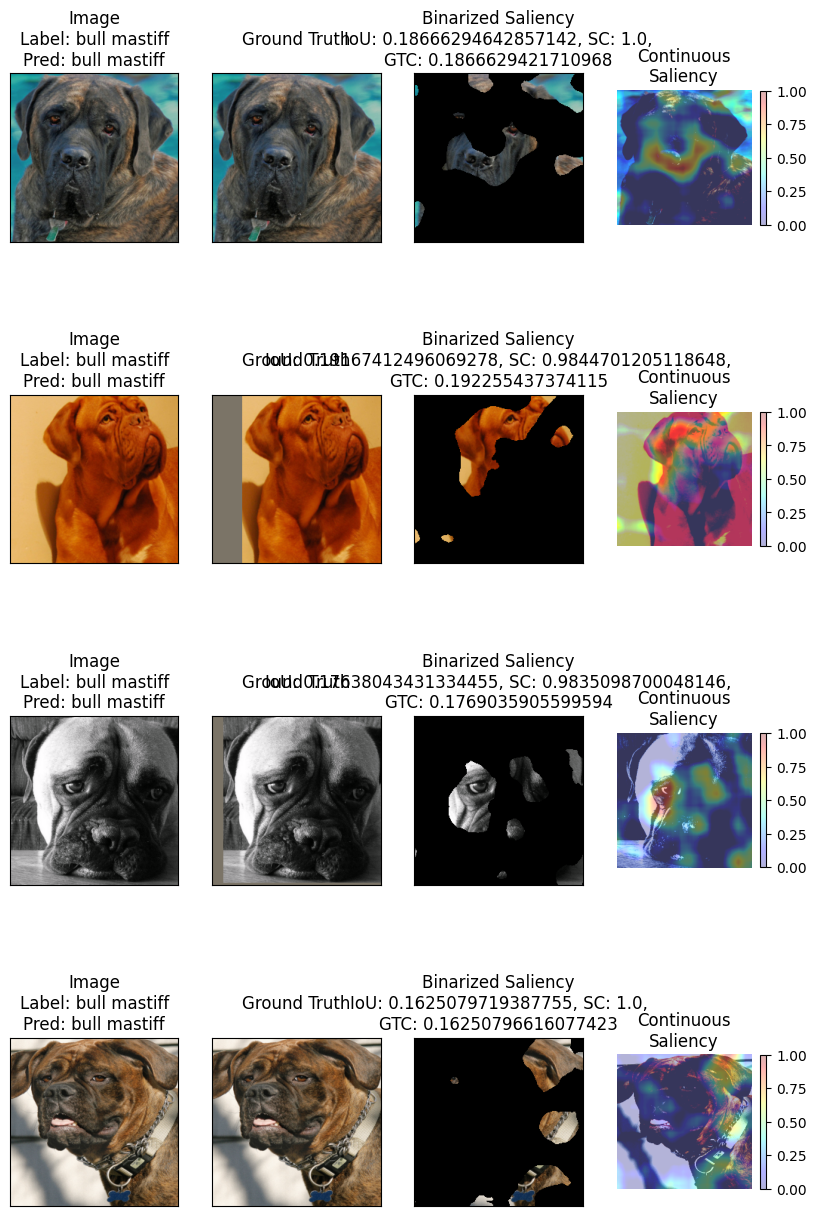

In [11]:
high_saliency_coverage_samples = np.where(shared_interest_scores["saliency_coverage"] > 0.98)
fig = display_images(high_saliency_coverage_samples[0].tolist(), dataset)